In [ ]:
import os
current_directory = os.getcwd()
import sys; sys.path.insert(0, current_directory)

In [4]:
import mne
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#### =========================================================================
#### Section 1: Data Loading Setup
#### This section defines a helper function to load data from pickle files
#### and sets up the directory paths for loading the pre-computed results
#### (from the previous script) that are ready for plotting.
#### =========================================================================

In [5]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pkl.load(f)
    return data

In [ ]:
# Define the folder path for loading EMD results
folder_load = "Results"
folder_pathload = os.path.join(os.getcwd(), folder_load)

# Define the folder path for evaluated inverse solutions (not used in this script but kept for context)
folder_name = "Evaluated_Data"
folder_path = os.path.join(os.getcwd(), folder_name)

folder_save = "Manuscript_Figures/Effect_of_ISC"
folder_pathsave = os.path.join(os.getcwd(), folder_save)
os.makedirs(folder_pathsave, exist_ok=True)

#### =========================================================================
#### Section 2: Main Plotting Loop
#### This is the primary execution block of the script. It systematically
#### iterates through different simulation parameters (SNR, spatial smoothness,
#### patch ranks, and source correlation). For each combination, it loads the
#### corresponding EMD results, calculates summary statistics, and generates
#### a comparative bar plot.
#### =========================================================================

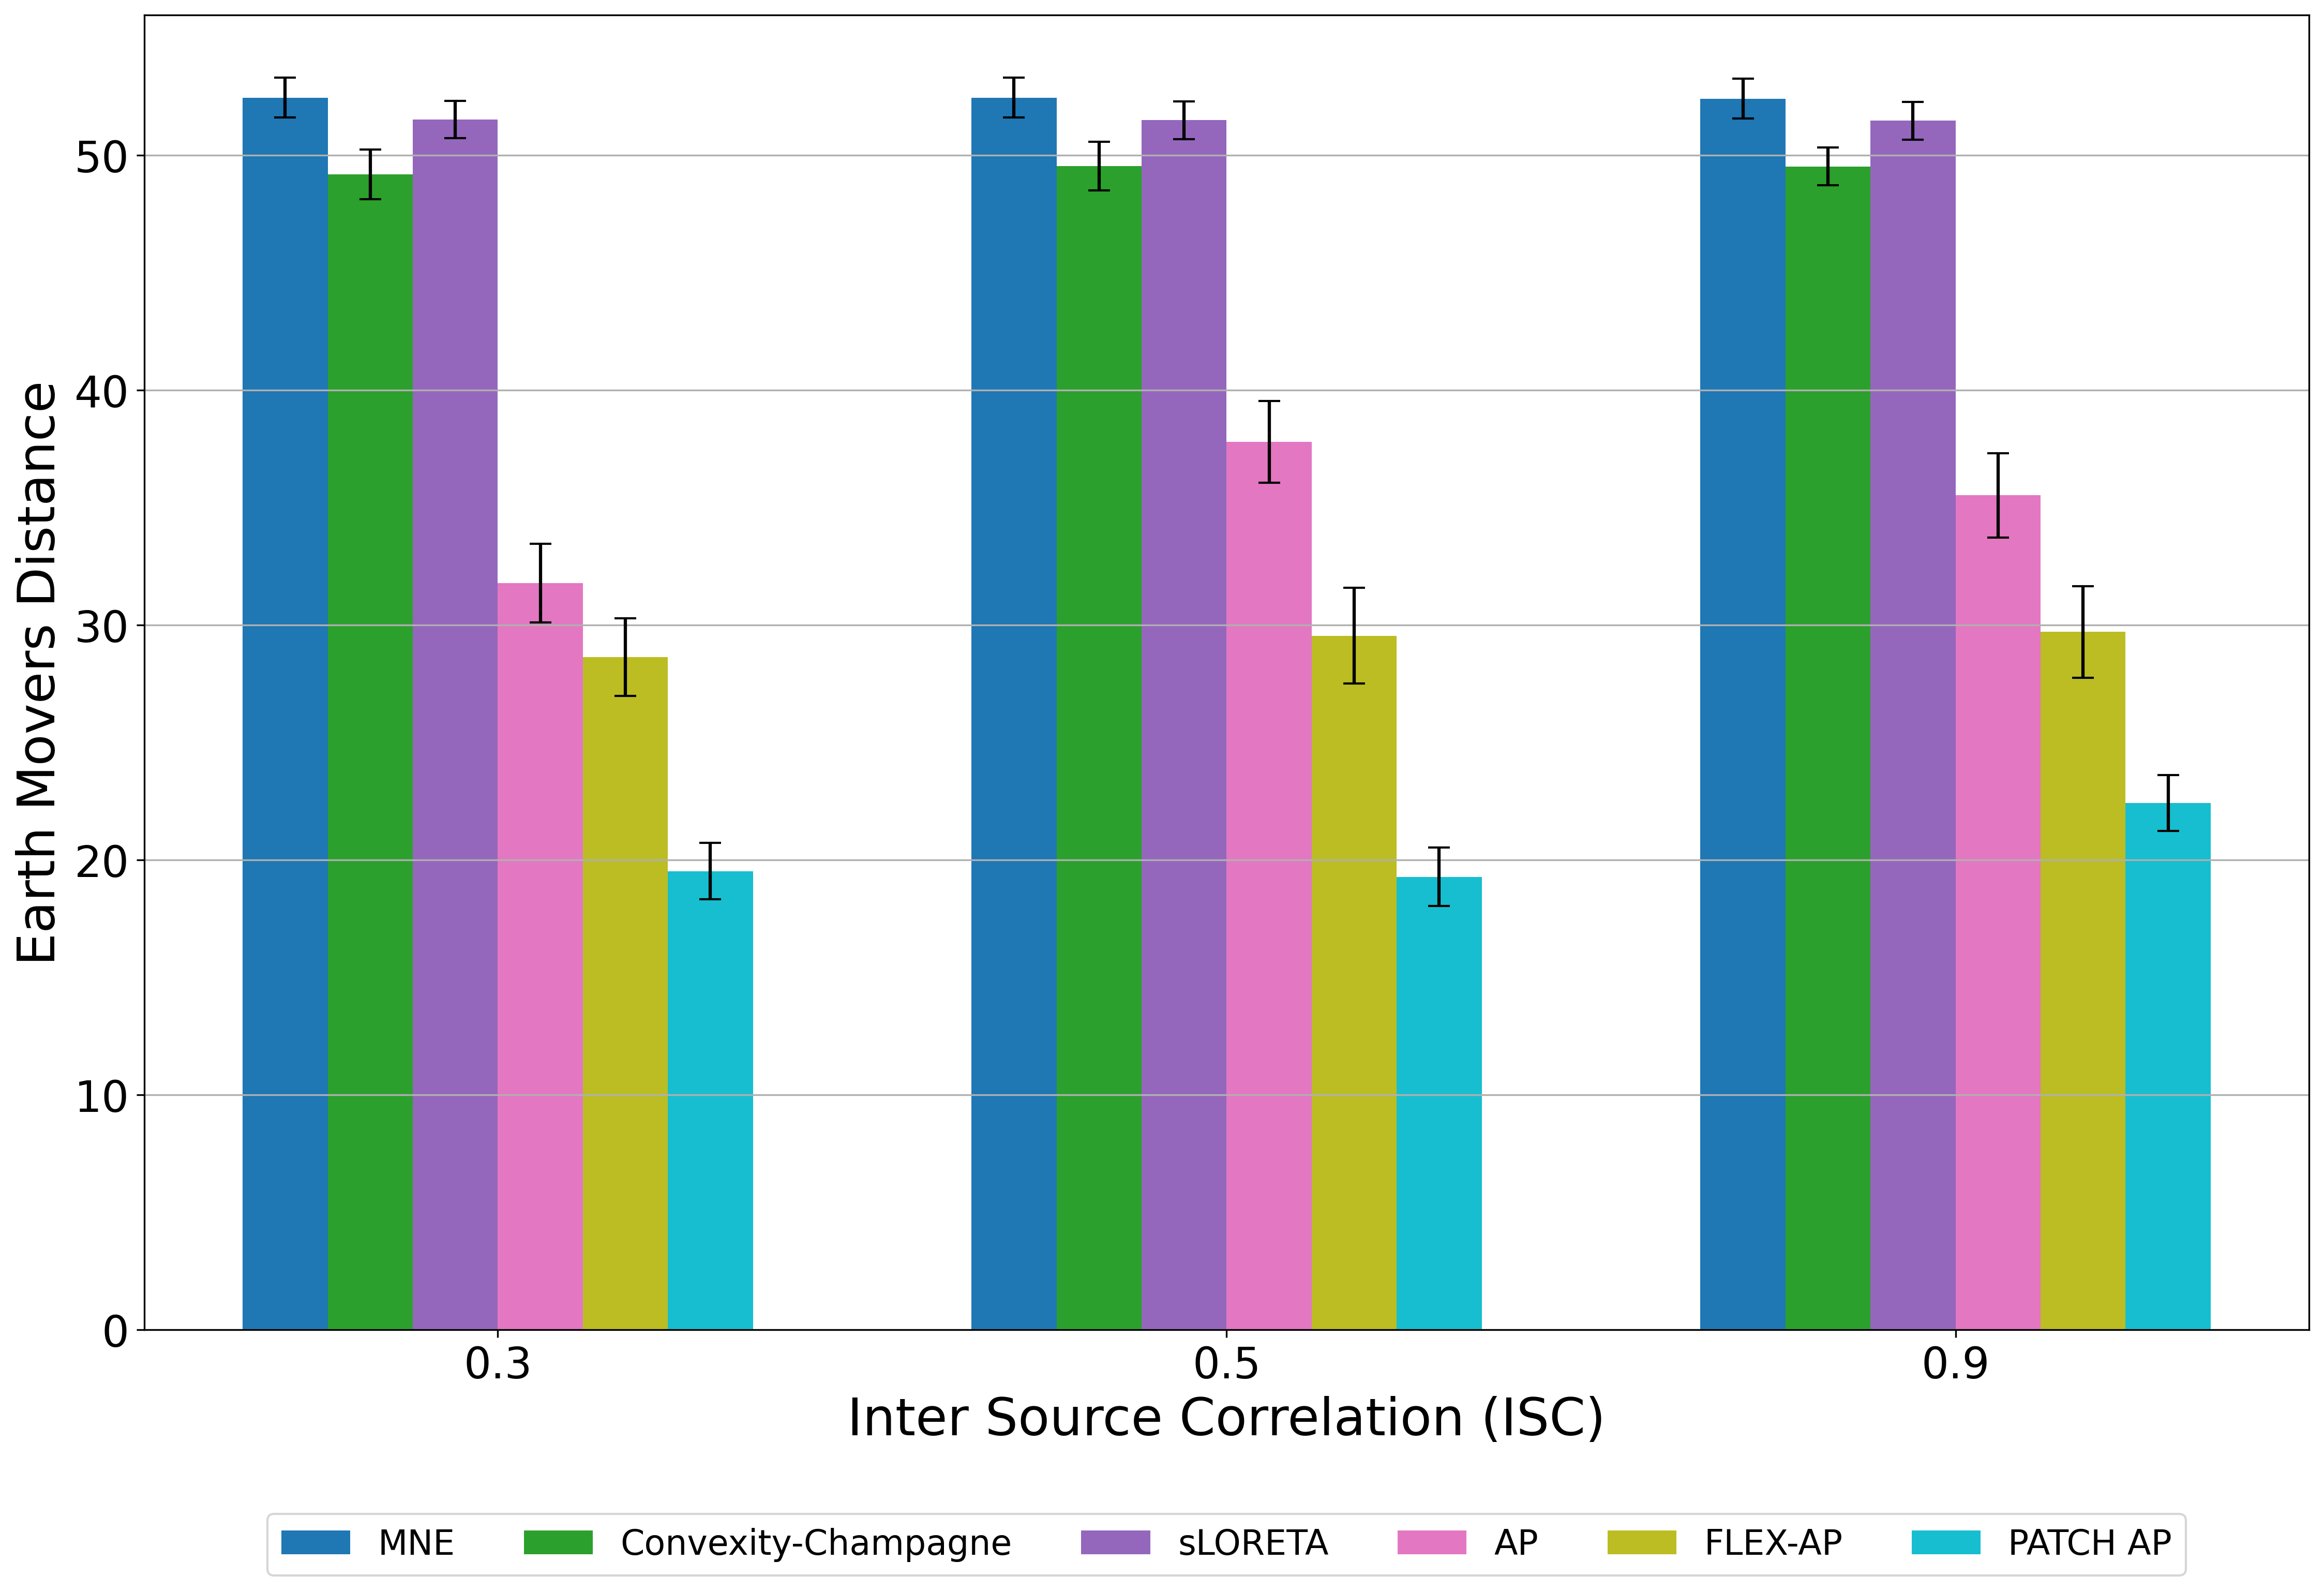

In [ ]:
batch_size = 250 # number of monte-carlo repettions 
plotmax = 1
inv_name = "coarse-80"
# Patchranks_Full  = [[1],[2],[3],[1,1],[1,2],[1,3],[2,2],[2,3],[1,2,3]]  
Patchranks_Full  = [[1,2]]         
for snr_db in range(0,5,5):
    for Smoothness_order in range(2,4,2):        
        for Patchranks in Patchranks_Full: 
            corr_coeffss = []   
            # Define lists to store EMD results for each SNR value
            all_medians_values = []
            all_std_devs_values = []                  
            for corr_coeff in [0.3,0.5,0.9]:
                start_time = time.time()
                # Iterate through all files in the folder
                filename = f"EMD_Len_{inv_name}_Data_corr_{corr_coeff}_smooth_{Smoothness_order}_patchranks_{Patchranks}_snr_{snr_db}.pkl"
                file_path = os.path.join(folder_pathload, filename)
                EMD_results = load_data(file_path)
                                
                # =====================================================
                # Subsection 2.1: Calculate Summary Statistics
                # This block processes the loaded EMD results. It calculates
                # the median and the standard error of the mean for each
                # source localization method, which will be used for the
                # bar heights and error bars in the plot.
                # =====================================================                                           
                EMD_medians = {}                
                EMD_stderr = {}  
                
                skip_keys = {"Patch RAP", "dSPM", "RAP-MUSIC", "FLEX-MUSIC"}
                for key, values in EMD_results.items():
                    if key in skip_keys:
                        continue
                    EMD_medians[key] = np.median(values)
                    EMD_stderr[key] = np.std(values) / np.sqrt(len(values))
              
                                                                                
                # Extract keys and values from medians and std_devs dictionaries
                method_names = list(EMD_medians.keys())
                medians_values = list(EMD_medians.values())
                std_devs_values = list( EMD_stderr.values())
                
                for im,aa in enumerate(method_names):
                    if method_names[im] == "Patch AP":
                        method_names[im] = "PATCH AP"
                    elif method_names[im] == "Patch RAP":
                        method_names[im] = "PATCH RAP"                                                
                
                # =====================================================
                # Subsection 2.2: Reorder Data for Consistent Plotting
                # To ensure the bars in the plot always appear in the same
                # order, this block reorders the methods and their statistics
                # according to a predefined list (`desired_order`).
                # =====================================================
                desired_order = ['dSPM', 'MNE', 'Convexity-Champagne','sLORETA','RAP-MUSIC','FLEX-MUSIC','PATCH RAP','AP','FLEX-AP',
                                 'PATCH AP']
                # Reorder the method names if they are available, otherwise ignore
                reordered_method_names, reordered_medians_values,reordered_std_devs_values = [],[],[]
                for method in desired_order:
                    if method in method_names:
                        index = method_names.index(method)
                        reordered_method_names.append(method)
                        reordered_medians_values.append(medians_values[index])
                        reordered_std_devs_values.append(std_devs_values[index])
                method_names = reordered_method_names
                medians_values = reordered_medians_values
                std_devs_values = reordered_std_devs_values
                
                all_medians_values.append(medians_values)
                all_std_devs_values.append(std_devs_values)                
                corr_coeffss.append(corr_coeff)
            
            # =========================================================
            # Section 3: Generate and Save the Plot
            # This section uses Matplotlib to create a detailed bar chart
            # comparing the performance (median EMD) of all localization
            # methods across different inter-source correlation values.
            # The final plot is then saved as a high-resolution image.
            # =========================================================
            # Set plot properties
            bar_width = 0.35
            fwd_name = inv_name
            
            # Plotting
            fig, ax = plt.subplots(figsize=(18, 11))
            
            # Define a fixed color map for methods
            cmap = plt.cm.tab10  # or 'tab20', 'Set2', etc.
            colors = cmap(np.linspace(0, 1, len(method_names)))
            method_colors = dict(zip(method_names, colors))

            
            # Plot bars for medians
            index = 0
            for ss, ssnr in enumerate(corr_coeffss):
                print(ssnr)
                medians_values = [vals for vals in all_medians_values[ss]]
                std_devs_values = [stds for stds in all_std_devs_values[ss]]
                                
                for ii, method_name in enumerate(method_names):
                    color = method_colors[method_name]
                    if ss == 0:
                        ax.bar(index + ii * bar_width, medians_values[ii], bar_width, yerr=std_devs_values[ii], capsize=5, label=method_name, color=color)
                    else:
                        ax.bar(index + ii * bar_width, medians_values[ii], bar_width, yerr=std_devs_values[ii], capsize=5, color=color)                    
                index = index+3                
            
            ax.set_xlabel('Inter Source Correlation (ISC)', fontsize=24) 
            ax.set_ylabel('Earth Movers Distance', fontsize=24) 
            # if fwd_name == "coarse-80":
            #     ax.set_title(f'No Model Error (Iteration = {batch_size}), Smoothing = {Smoothness_order}, Patchranks = {Patchranks}', fontsize=24)
            # elif fwd_name == "fine-80":
            #     ax.set_title(f'Source Space Model Error (Iteration = {batch_size}), Smoothing = {Smoothness_order}, Patchranks = {Patchranks}', fontsize=24)
            # elif  fwd_name == "fine-50":
            #     ax.set_title(f'Source Space + Conductivity Model Error (Iteration = {batch_size}), Smoothing = {Smoothness_order}, Patchranks = {Patchranks}', fontsize=24) 
            
            # Set the x-axis tick positions and labels
            ax.set_xticks(np.arange(len(corr_coeffss)) * len(method_names)/2 + (bar_width*len(method_names))/2 - bar_width/2)
            ax.set_xticklabels(corr_coeffss)
            
            # Adjust legend font size
            ax.legend(fontsize=20)
            ax.yaxis.grid(True)
            
            # Adjust tick label font size
            ax.tick_params(axis='both', which='major', labelsize=20)
            
            # Set legend outside the plot
            ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol = len(method_names),  fontsize=16)
            
            # plt.tight_layout()
            plt.show()
            
            filename = f"LEN_snr_db_{snr_db}_smooth_{Smoothness_order}_patchranks_{Patchranks}_inv_name_{inv_name}.png"
            figure_filename = os.path.join(folder_save, filename)
            print(figure_filename)
            fig.savefig(figure_filename, dpi=300, bbox_inches='tight', format='png')
            


            
            end_time = time.time()  # Record end time
            elapsed_time = end_time - start_time
            print(f"Elapsed time for corr_coeff={corr_coeff}, Smoothness_order={Smoothness_order}, Patchranks={Patchranks}, snr_db={snr_db}: {elapsed_time} seconds")